<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Joint reactions](02.02-joint-reactions.ipynb) | [Contents](Index.ipynb) |

# EMG
__warning__: experts-novices

In [1]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt
from pyosim import Conf
from pyomeca import Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    random_balanced_design,
    get_spm_cluster,
    ridge_plot
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Read files

In [3]:
project_path = Path("/media/romain/E/Projet_ExpertsNovices/opensim/")

In [4]:
def correct_path(x):
    return Path(
        x.replace("home/laboratoire/mnt/E", "/media/romain/E")
        .replace("E:", "/media/romain/E")
        .replace("1_inverse_kinematic", "0_emg")
        .replace(".mot", ".sto")
        .replace("wu_expertsnovicesD_", "")
        .replace("wu_expertsnovicesG_", "")
    )


def parse_conditions(d):
    return d.merge(
        pd.read_csv(project_path / "_conf.csv")[["participant", "group"]].rename(
            columns={"group": "expert"}
        ),
        on="participant",
    ).assign(
        fatigue=lambda x: x["filename"].str[0].astype(int) - 1,
        height=lambda x: x["filename"].str[2].astype("category"),
        mass=lambda x: x["filename"].str[3:5].astype(int),
        filename=lambda x: x["participant"] + "_" + x["filename"],
        participant=lambda x: x["participant"].astype("category"),
    )

In [5]:
LOAD = True
data_filename = project_path.parent / "emg" / "emg.csv"

if LOAD:
    emg = pd.read_csv(
        data_filename, dtype={i: "category" for i in ["participant", "height"]}
    )
else:
    emg = []
    f = []
    onsets = pd.read_csv(project_path / "onsets.csv")
    for _, ifile in onsets.iterrows():
        filename = correct_path(ifile["filepathK"])
        if filename in f:
            continue
        else:
            f.append(filename)
        try:
            e = Analogs3d.from_sto(filename)
        except FileNotFoundError:
            print(f"{filename} not found")
            continue

        idx = np.logical_and(
            e.get_time_frames < ifile["t_off"], e.get_time_frames > ifile["t_on"]
        )
        emg.append(
            e[..., idx]
            .time_normalization()
            .to_dataframe()
            .assign(filename=filename.stem, participant=filename.parent.parent.stem)
        )
    emg = (
        pd.concat(emg)
        .reset_index()
        .assign(index=lambda x: x["index"] / 100)
        .pipe(parse_conditions)
    )
    emg.to_csv(data_filename, index=False)

emg.sample(5)

,index,deltant,deltmed,deltpost,biceps,triceps,uptrap,pect,ssp,isp,subs,filename,participant,expert,fatigue,height,mass
37164,0.97,0.096415,0.053029,0.020504,0.009068,0.043201,0.060640,0.019440,0.080135,0.039671,0.000583,didl_1_r08_3,didl,0,0,r,8
9149,0.59,0.653153,0.712700,0.059881,0.242107,0.272157,0.412400,0.082562,0.312093,0.562050,0.124074,beng_1_r12_3,beng,0,0,r,12
107788,0.21,0.110401,0.041165,0.017279,0.530061,0.018112,0.163777,0.334200,0.049624,0.112284,0.122680,sylg_1_r08_3,sylg,0,0,r,8
19413,0.21,0.164830,0.046798,0.044822,0.490506,0.059253,0.120254,0.247399,0.163332,0.051060,0.047019,char_1_s08_1,char,0,0,s,8
109009,0.30,0.050891,0.011342,0.007309,0.083594,0.008536,0.048199,0.141064,0.007967,0.014706,0.054581,sylg_2_s12_4,sylg,0,1,s,12


## Clean data

### Keep only relative height and before fatigue

In [6]:
emg = emg.query('height == "r" & fatigue == 0').drop(["height", "fatigue"], axis=1)

### Balance dataset

In [7]:
emg.drop_duplicates(["filename", "participant"]).groupby(["expert", "mass"]).size()

expert  mass
0       8       76
        12      80
1       8       61
        12      46
dtype: int64

In [8]:
balanced_trials = random_balanced_design(
    emg, ["expert", "mass"], random_state=RANDOM_SEED, participant=True
)
_filename, _participant = (
    balanced_trials["filename"].to_list(),
    balanced_trials["participant"].to_list(),
)

In [9]:
emg = emg.query("filename == @_filename & participant == @_participant")
emg.drop_duplicates(["filename", "participant"]).groupby(["expert", "mass"]).size()

expert  mass
0       8       46
        12      46
1       8       46
        12      46
dtype: int64

## Time above 60%

In [10]:
id_vars = ["filename", "participant", "expert", "mass", "index"]

emg_melt = emg.melt(id_vars=id_vars)
emg_melt.head()

,filename,participant,expert,mass,index,variable,value
0,aled_1_r08_5,aled,0,8,0.00,deltant,0.160089
1,aled_1_r08_5,aled,0,8,0.01,deltant,0.140689
2,aled_1_r08_5,aled,0,8,0.02,deltant,0.125458
3,aled_1_r08_5,aled,0,8,0.03,deltant,0.122893
4,aled_1_r08_5,aled,0,8,0.04,deltant,0.132993


In [11]:
sup = (
    emg_melt.eval("sup = value > 0.6")
    .groupby(["filename", "expert", "mass"])["sup"]
    .apply(lambda x: x.sum() / x.shape[0])
    .reset_index()
)

sup.sample(5)

,filename,expert,mass,sup
58,davm_1_r12_6,1,12,0.088119
121,jull_1_r12_5,0,12,0.020792
104,jead_1_r08_6,1,8,0.000990
7,antc_1_r12_1,0,12,0.031683
136,nicl_1_r08_6,1,8,0.056436


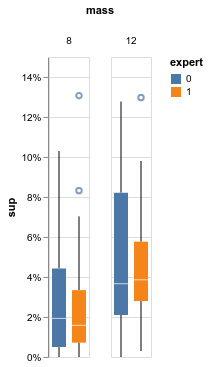

In [12]:
alt.Chart(sup).mark_boxplot().encode(
    alt.X(
        "expert:N", axis=alt.Axis(ticks=False, labels=False, domain=False), title=None
    ),
    alt.Y("sup", axis=alt.Axis(format="%")),
    alt.Color("expert:N"),
).facet(column="mass")

In [13]:
sup.head()

,filename,expert,mass,sup
0,aled_1_r08_5,0,8,0.032673
1,aled_1_r12_6,0,12,0.037624
2,antc_1_r08_1,0,8,0.000000
3,antc_1_r08_2,0,8,0.000000
4,antc_1_r08_3,0,8,0.002970


# Density

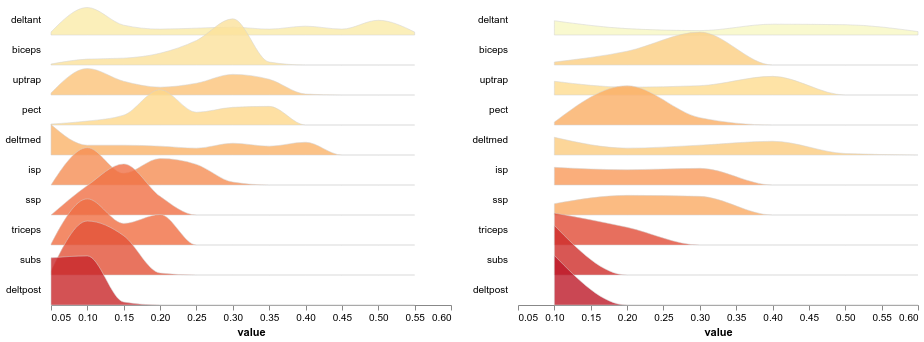

In [14]:
a = ridge_plot(
    emg_melt.query("expert == 1")
    .groupby(["variable", "index"])["value"]
    .mean()
    .reset_index(),
    value="value",
    groupby="variable",
    sort=emg_melt.groupby(["variable"])["value"]
    .mean()
    .sort_values(ascending=False)
    .index.to_list(),
)

b = ridge_plot(
    emg_melt.query("expert == 0")
    .groupby(["variable", "index"])["value"]
    .mean()
    .reset_index(),
    value="value",
    groupby="variable",
    sort=emg_melt.groupby(["variable"])["value"]
    .mean()
    .sort_values(ascending=False)
    .index.to_list(),
)

(a | b).resolve_scale(x="shared").configure_facet(spacing=0).configure_view(stroke=None)

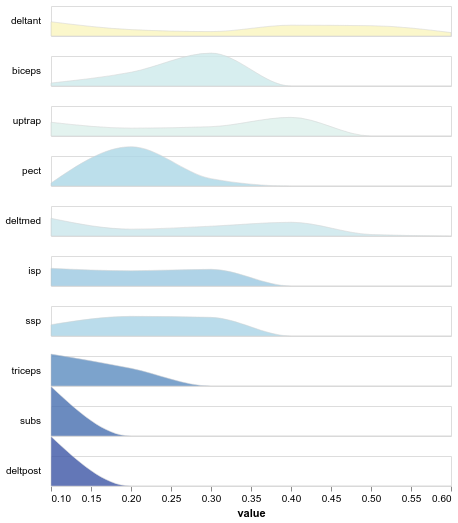

In [15]:
ridge_plot(
    emg_melt.query("expert == 0")
    .groupby(["variable", "index"])["value"]
    .mean()
    .reset_index(),
    value="value",
    groupby="variable",
    sort=emg_melt.groupby(["variable"])["value"]
    .mean()
    .sort_values(ascending=False)
    .index.to_list(),
)

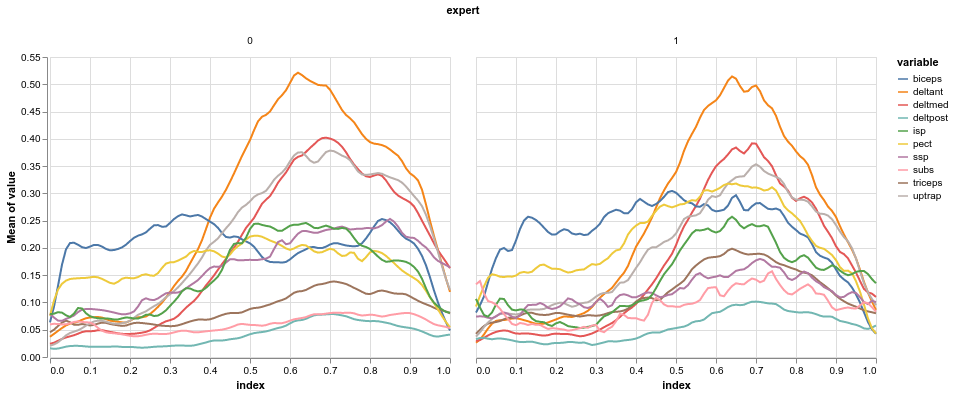

In [16]:
alt.Chart(emg_melt).mark_line().encode(
    alt.X("index"), alt.Y("mean(value)"), alt.Color("variable")
).facet(column="expert")

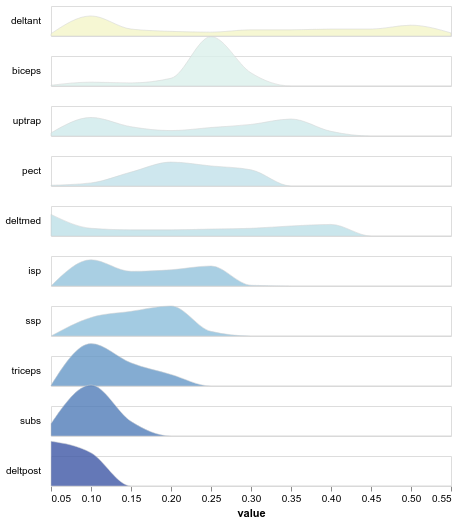

In [17]:
ridge_plot(
    emg_melt.groupby(["variable", "index"])["value"].mean().reset_index(),
    value="value",
    groupby="variable",
    sort=emg_melt.groupby(["variable"])["value"]
    .mean()
    .sort_values(ascending=False)
    .index.to_list(),
)

# $\sum$activation

In [18]:
sum_emg = emg_melt.groupby(id_vars)["value"].sum().reset_index()
sum_emg.head()

,filename,participant,expert,mass,index,value
0,aled_1_r08_5,aled,0,8,0.00,0.746035
1,aled_1_r08_5,aled,0,8,0.01,0.594940
2,aled_1_r08_5,aled,0,8,0.02,0.541461
3,aled_1_r08_5,aled,0,8,0.03,0.599043
4,aled_1_r08_5,aled,0,8,0.04,0.743934


In [19]:
y = (
    sum_emg.assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index(id_vars)
    .unstack()
)
y.head()

value                                \
index                                     0.00      0.01      0.02      0.03   
filename     participant expert mass                                           
aled_1_r08_5 0           0      8     0.746035  0.594940  0.541461  0.599043   
aled_1_r12_6 0           0      12    1.417746  1.322175  1.271385  1.283805   
antc_1_r08_1 1           0      8     0.474202  0.469738  0.472110  0.515858   
antc_1_r08_2 1           0      8     0.491948  0.490786  0.490844  0.505098   
antc_1_r08_3 1           0      8     0.462647  0.535660  0.565404  0.557258   

                                                                              \
index                                     0.04      0.05      0.06      0.07   
filename     participant expert mass                                           
aled_1_r08_5 0           0      8     0.743934  0.925106  1.084680  1.178946   
aled_1_r12_6 0           0      12    1.349719  1.448614  1.558951  1.654325   
antc_1_r08_1 1           0      8     0.513057  0.452044  0.450066  0.543215   
antc_1_r08_2 1           0      8     0.540982  0.584143  0.606833  0.598582   
antc_1_r08_3 1           0      8     0.540130  0.533954  0.533763  0.524811   

                                                          ...            \
index                                     0.08      0.09  ...      0.91   
filename     participant expert mass                      ...             
aled_1_r08_5 0           0      8     1.192587  1.140214  ...  1.708016   
aled_1_r12_6 0           0      12    1.710763  1.724221  ...  2.595966   
antc_1_r08_1 1           0      8     0.608976  0.556372  ...  0.463883   
antc_1_r08_2 1           0      8     0.577775  0.573355  ...  0.742186   
antc_1_r08_3 1           0      8     0.504877  0.494214  ...  1.395113   

                                                                              \
index                                     0.92      0.93      0.94      0.95   
filename     participant expert mass                                           
aled_1_r08_5 0           0      8     1.481791  1.339513  1.269601  1.236507   
aled_1_r12_6 0           0      12    2.448522  2.275585  2.093492  1.910984   
antc_1_r08_1 1           0      8     0.413402  0.312199  0.255365  0.250827   
antc_1_r08_2 1           0      8     0.767451  0.863537  0.964234  1.016262   
antc_1_r08_3 1           0      8     1.395238  1.294889  1.109589  0.918320   

                                                                              \
index                                     0.96      0.97      0.98      0.99   
filename     participant expert mass                                           
aled_1_r08_5 0           0      8     1.202361  1.141917  1.048799  0.935497   
aled_1_r12_6 0           0      12    1.737028  1.582877  1.454272  1.351514   
antc_1_r08_1 1           0      8     0.257570  0.258600  0.255001  0.247311   
antc_1_r08_2 1           0      8     1.004663  0.938128  0.839521  0.754996   
antc_1_r08_3 1           0      8     0.793949  0.748989  0.737770  0.706940   

                                                
index                                     1.00  
filename     participant expert mass            
aled_1_r08_5 0           0      8     0.828790  
aled_1_r12_6 0           0      12    1.278423  
antc_1_r08_1 1           0      8     0.237642  
antc_1_r08_2 1           0      8     0.726062  
antc_1_r08_3 1           0      8     0.649163  

[5 rows x 101 columns]

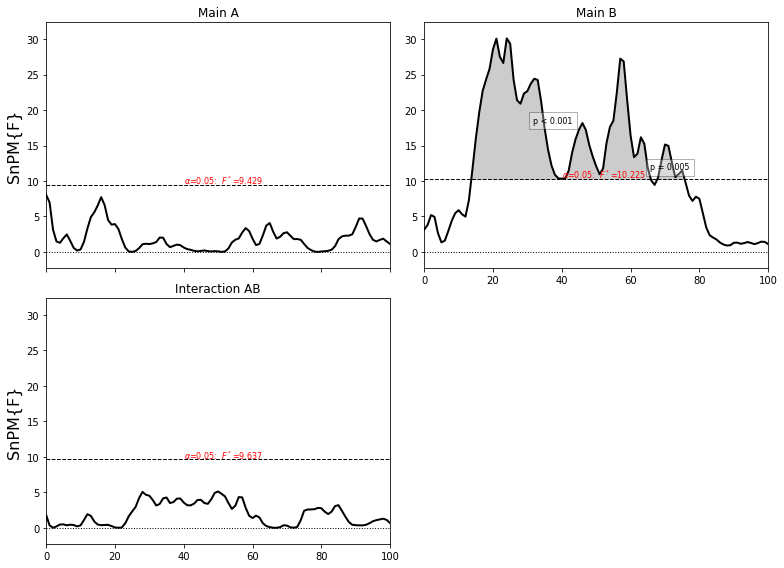

In [20]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(),
    A=y.index.get_level_values("expert"),
    B=y.index.get_level_values("mass"),
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [21]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main expertise",
        "Main B": "main mass",
        "Interaction AB": "interaction expertise-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main mass,0,0.135594,0.6527
1,main mass,0.00533333,0.670728,0.749797


In [22]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [23]:
base = alt.Chart(sum_emg).encode(
    alt.X("index", title="normalized trial", axis=alt.Axis(format="%"))
)
mu = base.mark_line().encode(alt.Y("mean(value)", title="Σ activation"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))

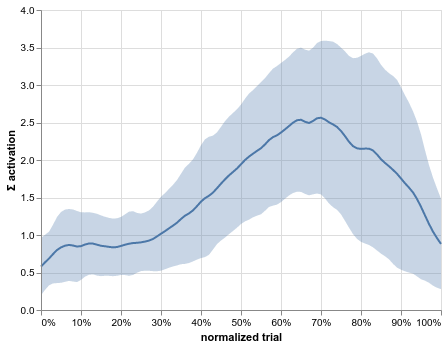

In [24]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

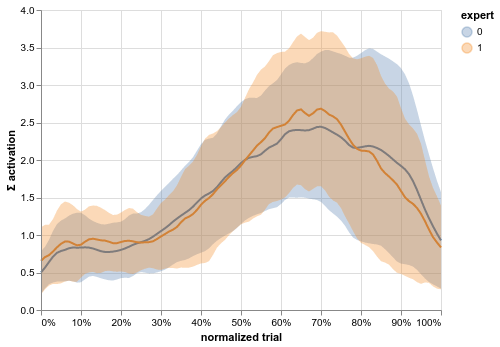

In [22]:
c.transform_filter('datum.effect == "main expertise"') + (mu + sigma).encode(
    alt.Color("expert:N")
)

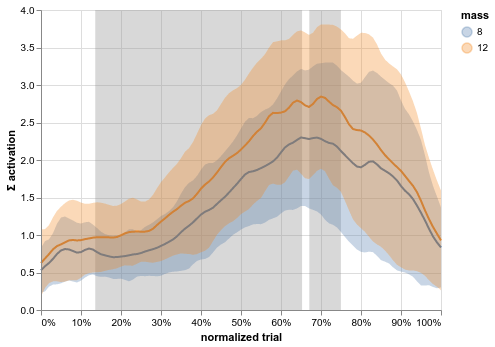

In [23]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

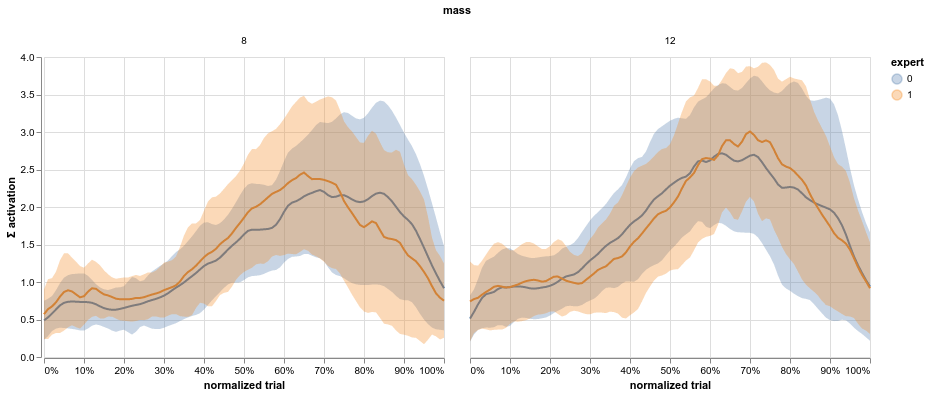

In [24]:
(mu + sigma).encode(alt.Color("expert:N")).facet(column="mass")

## ECDF

### ECDF on activations

In [25]:
emg_melt["ecdf"] = emg_melt.groupby("filename")["value"].transform(
    lambda x: x.rank(method="first") / x.shape[0]
)

In [26]:
emg_melt.groupby("filename").size().rename("size").to_frame().query("size != 1010")

,size
filename,


In [27]:
target_col_shape = 100

y = (
    emg_melt.drop(["index", "variable"], axis=1)
    .assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index([i if i != "index" else "ecdf" for i in id_vars])
    .unstack()
)
y = y.iloc[:, 0 :: int(y.shape[1] / target_col_shape)]
y.head()

value                                \
ecdf                                  0.000990  0.010891  0.020792  0.030693   
filename     participant expert mass                                           
aled_1_r08_5 0           0      8     0.002082  0.010173  0.012448  0.016120   
aled_1_r12_6 0           0      12    0.006464  0.019429  0.023954  0.026103   
antc_1_r08_1 1           0      8     0.003233  0.004061  0.006994  0.008088   
antc_1_r08_2 1           0      8     0.007291  0.011922  0.014298  0.015367   
antc_1_r08_3 1           0      8     0.008858  0.012466  0.013759  0.017365   

                                                                              \
ecdf                                  0.040594  0.050495  0.060396  0.070297   
filename     participant expert mass                                           
aled_1_r08_5 0           0      8     0.018345  0.020712  0.022511  0.023998   
aled_1_r12_6 0           0      12    0.029161  0.031630  0.032913  0.033777   
antc_1_r08_1 1           0      8     0.009418  0.010324  0.011000  0.012001   
antc_1_r08_2 1           0      8     0.017750  0.020340  0.021242  0.022467   
antc_1_r08_3 1           0      8     0.019527  0.021328  0.023076  0.024163   

                                                          ...            \
ecdf                                  0.080198  0.090099  ...  0.901980   
filename     participant expert mass                      ...             
aled_1_r08_5 0           0      8     0.025032  0.026775  ...  0.460550   
aled_1_r12_6 0           0      12    0.034913  0.036323  ...  0.511293   
antc_1_r08_1 1           0      8     0.012906  0.013380  ...  0.167933   
antc_1_r08_2 1           0      8     0.023227  0.023992  ...  0.247168   
antc_1_r08_3 1           0      8     0.026094  0.027260  ...  0.346643   

                                                                              \
ecdf                                  0.911881  0.921782  0.931683  0.941584   
filename     participant expert mass                                           
aled_1_r08_5 0           0      8     0.475136  0.493574  0.516622  0.541052   
aled_1_r12_6 0           0      12    0.523567  0.537730  0.550176  0.567877   
antc_1_r08_1 1           0      8     0.177284  0.189337  0.197272  0.211626   
antc_1_r08_2 1           0      8     0.259724  0.269277  0.279812  0.293786   
antc_1_r08_3 1           0      8     0.361594  0.371425  0.390099  0.403511   

                                                                              \
ecdf                                  0.951485  0.961386  0.971287  0.981188   
filename     participant expert mass                                           
aled_1_r08_5 0           0      8     0.553292  0.575775  0.613145  0.646459   
aled_1_r12_6 0           0      12    0.578313  0.599354  0.625009  0.646970   
antc_1_r08_1 1           0      8     0.227044  0.246541  0.267978  0.309684   
antc_1_r08_2 1           0      8     0.309890  0.314408  0.349939  0.383526   
antc_1_r08_3 1           0      8     0.416458  0.434039  0.459006  0.478494   

                                                
ecdf                                  0.991089  
filename     participant expert mass            
aled_1_r08_5 0           0      8     0.687085  
aled_1_r12_6 0           0      12    0.724760  
antc_1_r08_1 1           0      8     0.340562  
antc_1_r08_2 1           0      8     0.421872  
antc_1_r08_3 1           0      8     0.536458  

[5 rows x 101 columns]

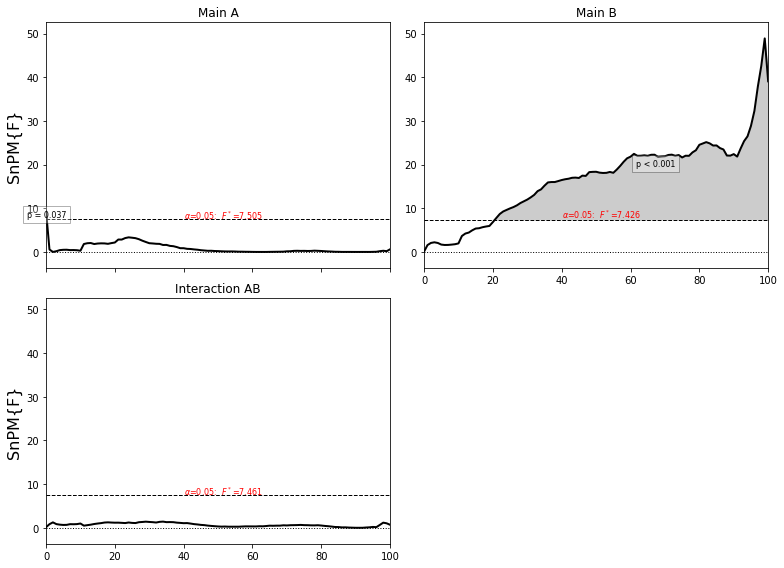

In [28]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(),
    A=y.index.get_level_values("expert"),
    B=y.index.get_level_values("mass"),
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [29]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main expertise",
        "Main B": "main mass",
        "Interaction AB": "interaction expertise-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main expertise,0.0373333,0,0.00214678
1,main mass,0,0.204262,0.990099


In [30]:
base = alt.Chart(y.stack().reset_index()).encode(
    alt.X("ecdf", axis=alt.Axis(format="%"), title="ecdf")
)
mu = base.mark_line().encode(
    alt.Y("mean(value)", title="activation", axis=alt.Axis(format="%"))
)
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))

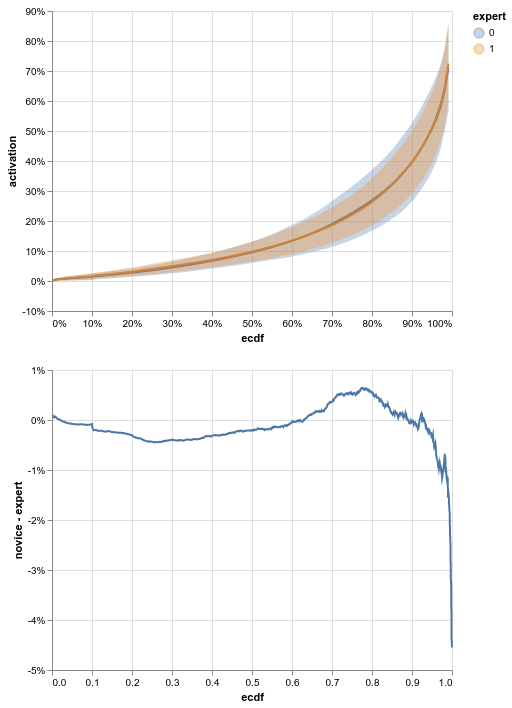

In [31]:
alt.Chart(clusters).mark_rect(opacity=0.3, color="grey").encode(
    alt.X("start"), alt.X2("end")
).transform_filter('datum.effect == "main expertise"') + (mu + sigma).encode(
    alt.Color("expert:N")
) & alt.Chart(
    emg_melt.pivot_table(index="ecdf", columns="expert", values="value", aggfunc="mean")
    .add_prefix("c")
    .eval("sub = c0 - c1")
    .reset_index()
).mark_line().encode(
    alt.X("ecdf"), alt.Y("sub", title="novice - expert", axis=alt.Axis(format="%"))
)

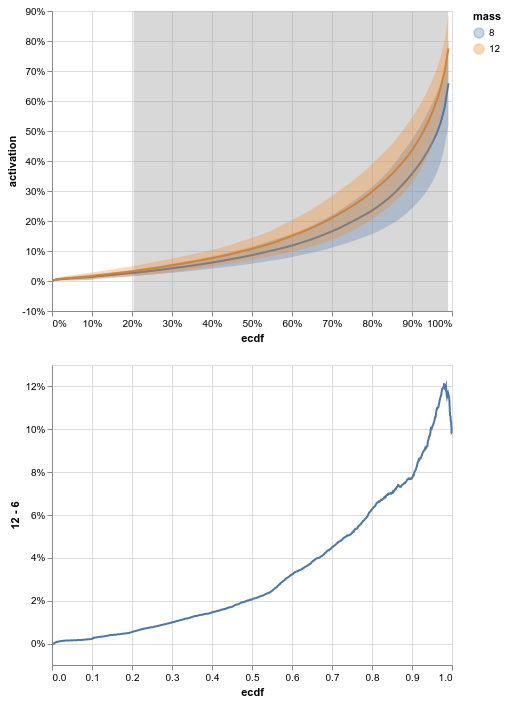

In [32]:
alt.Chart(clusters).mark_rect(opacity=0.3, color="grey").encode(
    alt.X("start"), alt.X2("end")
).transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
) & alt.Chart(
    emg_melt.pivot_table(index="ecdf", columns="mass", values="value", aggfunc="mean")
    .add_prefix("c")
    .eval("sub = c12 - c8")
    .reset_index()
).mark_line().encode(
    alt.X("ecdf"), alt.Y("sub", title="12 - 6", axis=alt.Axis(format="%"))
)

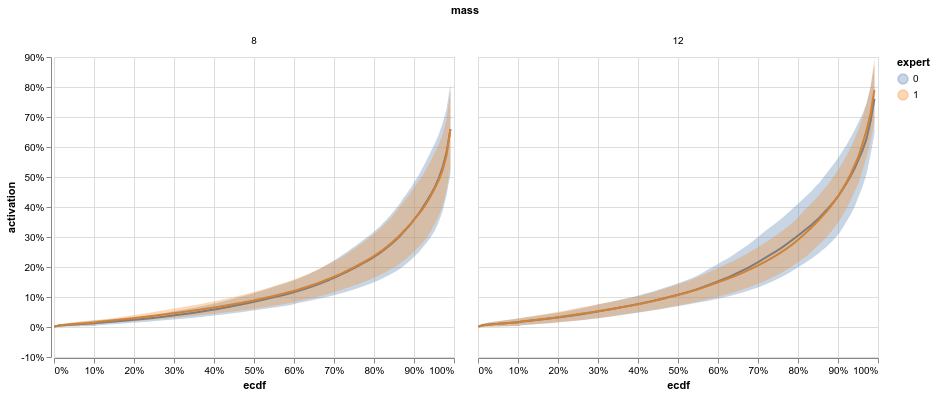

In [33]:
(mu + sigma).encode(alt.Color("expert:N")).facet(column="mass")

## $\sum\sum\text{activations}$

In [34]:
sum_sum_emg = (
    sum_emg.groupby([i for i in id_vars if i != "index"])["value"].sum().reset_index()
)
sum_sum_emg.head()

,filename,participant,expert,mass,value
0,aled_1_r08_5,aled,0,8,196.315507
1,aled_1_r12_6,aled,0,12,237.830295
2,antc_1_r08_1,antc,0,8,76.370010
3,antc_1_r08_2,antc,0,8,111.825011
4,antc_1_r08_3,antc,0,8,150.931016


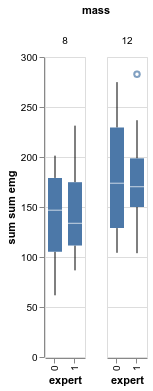

In [35]:
alt.Chart().mark_boxplot().encode(
    alt.X("expert:N"), alt.Y("value", title="sum sum emg")
).facet(data=sum_sum_emg, column=alt.Column("mass"))

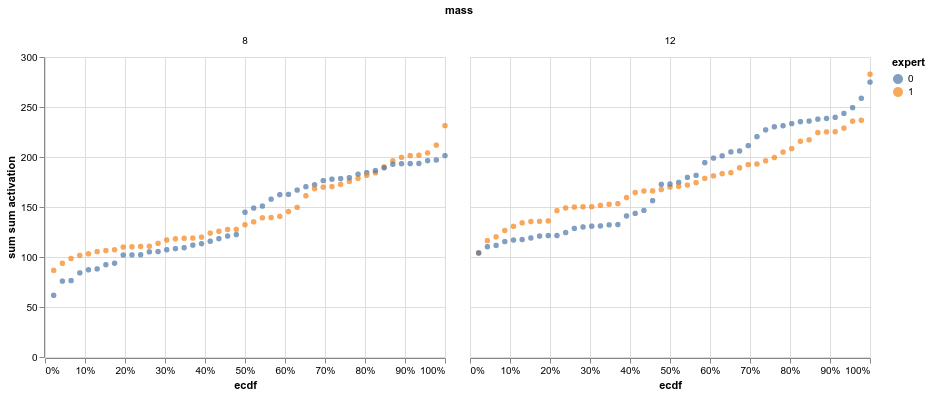

In [36]:
alt.Chart(
    sum_sum_emg.assign(
        ecdf=lambda x: x.groupby(["expert", "mass"])["value"].transform(
            lambda x: x.rank(method="first") / x.shape[0]
        )
    )
).mark_circle().encode(
    alt.X("ecdf", axis=alt.Axis(format="%")),
    alt.Y("value", title="sum sum activation"),
    alt.Color("expert:N"),
    alt.Column("mass"),
)

<!--NAVIGATION-->
< [Joint reactions](02.02-joint-reactions.ipynb) | [Contents](Index.ipynb) |